# Advanced Lane Finding Project

The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
- Video pipeline

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
%matplotlib inline

# Apply a distortion correction to raw images.

In [2]:
test_images_path = glob.glob('./test_images/*.jpg')

In [3]:
print(test_images_path)

['./test_images\\straight_lines1.jpg', './test_images\\straight_lines2.jpg', './test_images\\test1.jpg', './test_images\\test2.jpg', './test_images\\test3.jpg', './test_images\\test4.jpg', './test_images\\test5.jpg', './test_images\\test6.jpg']


# Load test images

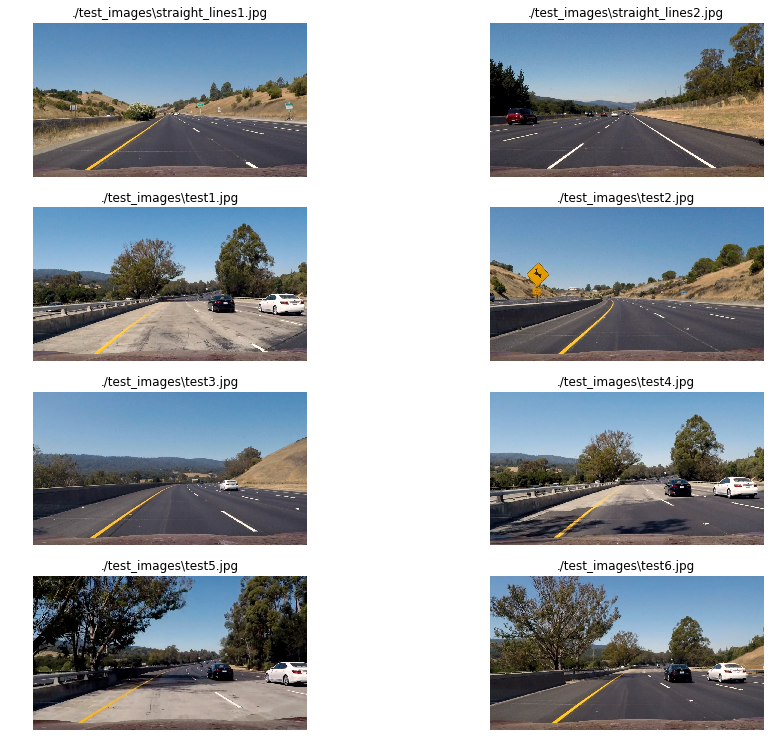

In [4]:
rows = 4
cols = 2
images_length = len(test_images_path)

fig, axes = plt.subplots(rows, cols, figsize=(15,13))
for ax, index in zip(axes.flat, range(cols * rows)):
    if index < images_length:
        image_path_name = test_images_path[index]
        image = mpimg.imread(image_path_name)
        ax.imshow(image)
        ax.set_title(image_path_name)
        ax.axis('off')

# Camera calibration

In [5]:
calibration_images_path = glob.glob('./camera_cal/c*.jpg')

### Calibration images

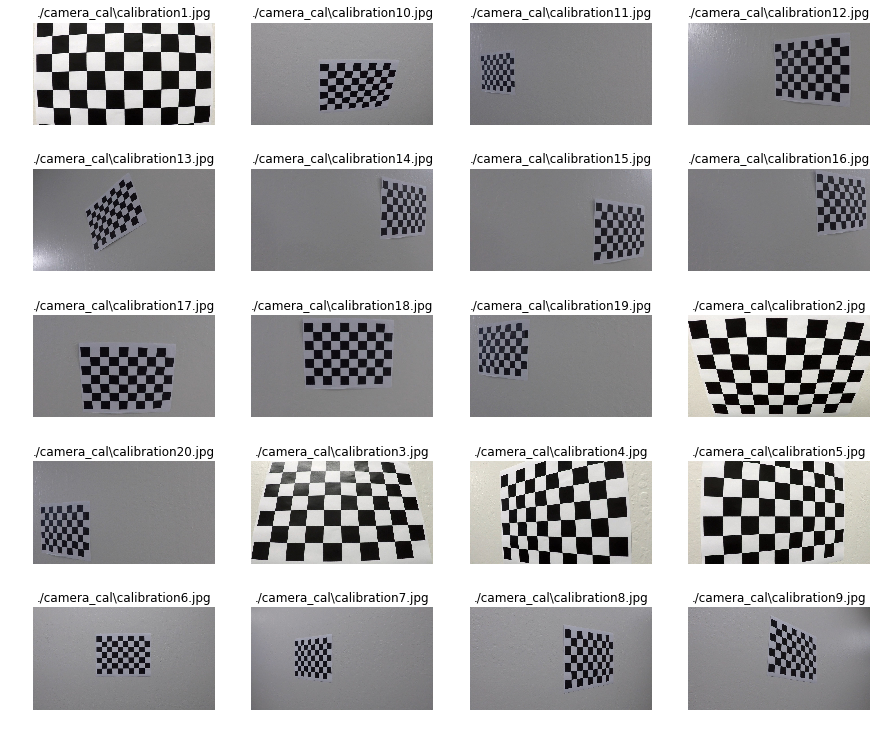

In [6]:
# display calibration images for distortion correction
rows = 5
cols = 4
image_length = len(calibration_images_path)

fig, axes = plt.subplots(rows, cols, figsize=(15,13))
for ax, index in zip(axes.flat, range(cols * rows)):
    if index < image_length:
        image_path_name = calibration_images_path[index]
        image = mpimg.imread(image_path_name)
        ax.imshow(image)
        ax.set_title(image_path_name)
        ax.axis('off')


In [7]:
# finding corners
# for future image undistortion
objpoints = []
imgpoints = []
outimages = []
originalImages = []

objp = np.zeros((6*9,3), np.float32) 
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x and y cordinates.

for image_path in calibration_images_path:
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        img_points = cv2.drawChessboardCorners(image.copy(), (9,6), corners, ret)
        outimages.append(img_points)
        originalImages.append(image)


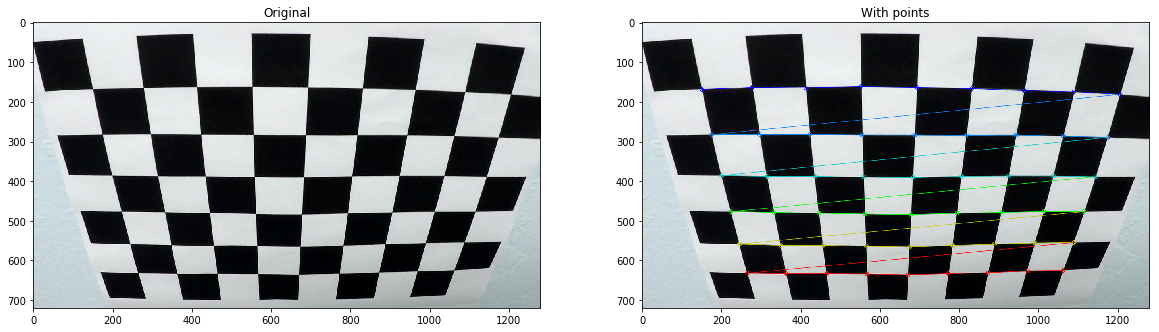

In [8]:
# finding corners
index = 10
original = originalImages[index]
chessPoints = outimages[index]
fig, axes = plt.subplots(ncols=2, figsize=(20, 10))

# original image
axes[0].imshow(original)
axes[0].set_title('Original')

# corners
axes[1].imshow(chessPoints)
axes[1].set_title('With points')

In [9]:
ret, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, original.shape[0:2], None, None)

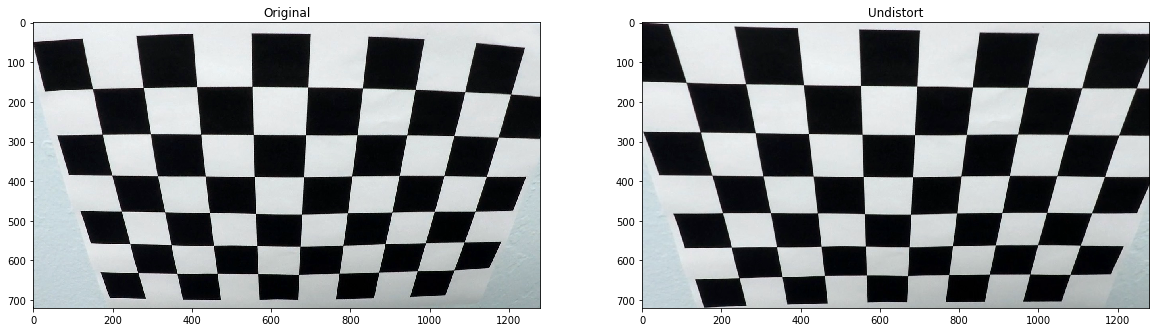

In [10]:
# display example of undistort chessboard
undist = cv2.undistort(original, mtx, dist, None, mtx)

fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
# origin image
axes[0].imshow(original)
axes[0].set_title('Original')

# undistorted
axes[1].imshow(undist)
axes[1].set_title('Undistort')

# Lane Image Distortion

In [11]:
# Loading camera calibration
camera_calibration = pickle.load( open('./pickled_data/camera_calibration.p', 'rb' ) )
mtx, dist = map(camera_calibration.get, ('mtx', 'dist'))

(-0.5, 1279.5, 719.5, -0.5)

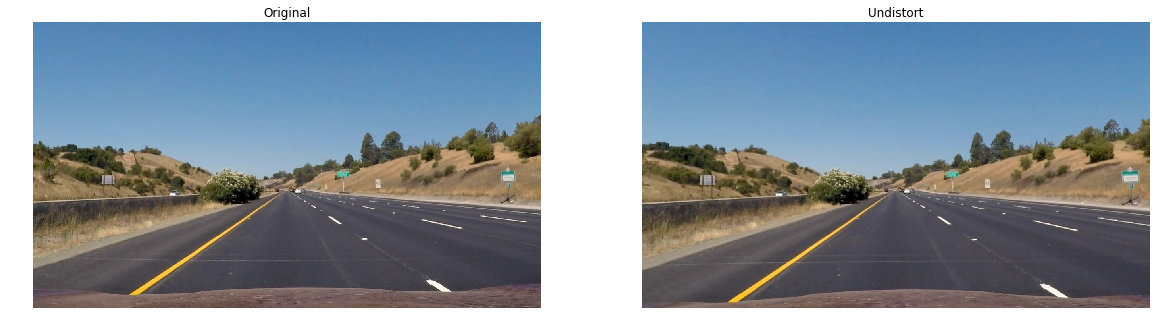

In [12]:
# origin image
origin_image_sample = mpimg.imread(test_images_path[0])

# undistorted
undistorted_image = cv2.undistort(origin_image_sample, mtx, dist, None, mtx)

fig, axes = plt.subplots(ncols=2, figsize=(20,10))
# origin on left
axes[0].imshow(origin_image_sample)
axes[0].set_title('Original')
axes[0].axis('off')

# Undistort on Right
axes[1].imshow(undistorted_image)
axes[1].set_title('Undistort')
axes[1].axis('off')

# Use color transforms, gradients, etc., to create a thresholded binary image.


In [13]:
def generate_undistorted_HLS(image, mtx=mtx, dist=dist):
   
    # Undistort the image with `mtx`, `dist` and convert it to HLS.

    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)


In [14]:
def absSobelThresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
   
    # Calculate the Sobel gradient on the direction `orient` and return a binary thresholded image 
    # on [`thresh_min`, `thresh_max`]. Using `sobel_kernel` as Sobel kernel size.
    
    if orient == 'x':
        yorder = 0
        xorder = 1
    else:
        yorder = 1
        xorder = 0
        
    sobel = cv2.Sobel(img, cv2.CV_64F, xorder, yorder, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255.0*abs_sobel/np.max(abs_sobel))
    
    # Applies a threshold to the `img` using [`thresh_min`, `thresh_max`] returning a binary image [0, 255]
    xbinary = np.zeros_like(scaled)
    xbinary[(scaled >= thresh_min) & (scaled <= thresh_max)] = 1
    
    return xbinary


## Combining Sobels and Saturation

In [15]:
def combined_gradients_binarize(img):
    
    # Compute the combination of Sobel X and Sobel Y or Magnitude and Direction
   
    sobelX = absSobelThresh(generate_undistorted_HLS(img)[:,:,2], thresh_min=10, thresh_max=160)
    sobelY = absSobelThresh(generate_undistorted_HLS(img)[:,:,2], orient='y', thresh_min=10, thresh_max=160)
    combined = np.zeros_like(sobelX) 
    combined[((sobelX == 1) & (sobelY == 1))] = 1
    return combined

In [16]:
### binary images

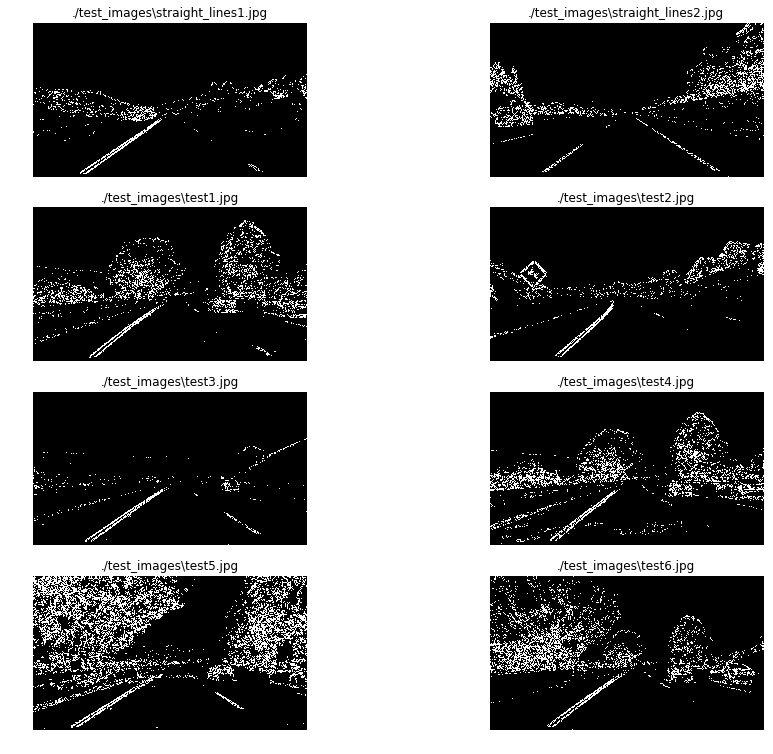

In [17]:
rows = 4
cols = 2
images_length = len(test_images_path)

fig, axes = plt.subplots(rows, cols, figsize=(15,13))
for ax, index in zip(axes.flat, range(cols * rows)):
    if index < images_length:
        image_path_name = test_images_path[index]
        image = mpimg.imread(image_path_name)
        resultCombined = combined_gradients_binarize(image)
        ax.imshow(resultCombined, cmap='gray')
        ax.set_title(image_path_name)
        ax.axis('off')

# Apply bird eye view perspective transform

In [18]:
# read image sample
original_image_path = test_images_path[0]
original = mpimg.imread(original_image_path)

# undistort image
undist = cv2.undistort(original, mtx, dist, None, mtx)

img_size = (gray.shape[1], gray.shape[0])

# set required information
corners = np.float32([[585, 455],[705, 455], [1130, 720], [190, 720]])
offset=200
#new_top_left=np.array([corners[0,0],0])
#new_top_right=np.array([corners[3,0],0])
src = np.float32([corners[0],corners[1],corners[2],corners[3]])
dst = np.float32([ [offset, 0],
    [img_size[0]-offset, 0],
    [img_size[0]-offset, img_size[1]], 
    [offset, img_size[1]]])    

# convert to gray
gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)

# perspective transform

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(undist, M, img_size)



(-0.5, 1279.5, 719.5, -0.5)

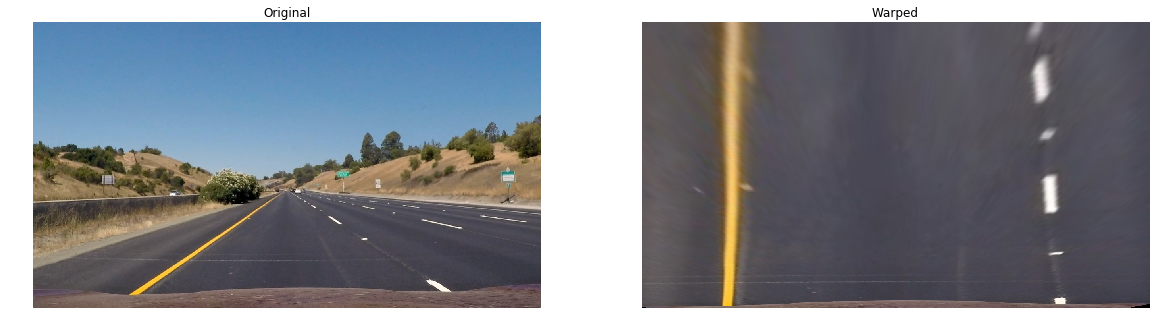

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(20,10))
# origin on left
axes[0].imshow(original)
axes[0].set_title('Original')
axes[0].axis('off')

# Warped on Right
axes[1].imshow(warped)
axes[1].set_title('Warped')
axes[1].axis('off')

In [20]:
pickle.dump( { 'M': M, 'Minv': Minv }, open('./pickled_data/perspective_transform.p', 'wb'))

In [21]:
transMatrix = pickle.load( open('./pickled_data/perspective_transform.p', 'rb' ) )
M, Minv = map(transMatrix.get, ('M', 'Minv'))

In [22]:
def generate_binary_warped(img):   
        # undistort
        undistorted_image = cv2.undistort(img, mtx, dist, None, mtx)
        # convert to gray
        gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
        
        # combine different threshold and binarize the image
        resultCombined = combined_gradients_binarize(undistorted_image)
        
        # warped
        img_size = (resultCombined.shape[1], resultCombined.shape[0])
        binary_warped = cv2.warpPerspective(resultCombined, M, img_size)
        
        return binary_warped

### Binary Warped

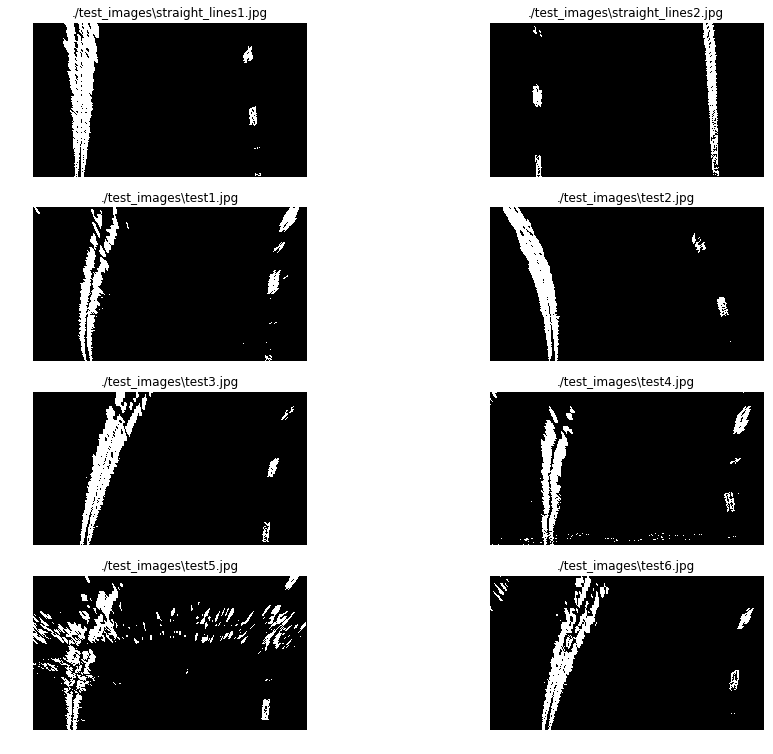

In [23]:
rows = 4
cols = 2
images_length = len(test_images_path)


# save for future useage
warped_binary_images = []

fig, axes = plt.subplots(rows, cols, figsize=(15,13))
for ax, index in zip(axes.flat, range(cols * rows)):
    if index < images_length:
        image_path_name = test_images_path[index]
        image = mpimg.imread(image_path_name)
        
        binary_warped = generate_binary_warped(image)
        
        #save for future used
        warped_binary_images.append(binary_warped)
        
        ax.imshow(binary_warped, cmap='gray')
        ax.set_title(image_path_name)
        ax.axis('off')


# Detect lane pixels and fit to find the lane boundary

In [24]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def findLines(image, nwindows=9, margin=110, minpix=50):
    
   # Find the polynomial representation of the lines in the `image` using:
    ## `nwindows` as the number of windows.
    ## `margin` as the windows margin.
    ## `minpix` as minimum number of pixes found to recenter the window.
    ## `ym_per_pix` meters per pixel on Y.
    ## `xm_per_pix` meters per pixels on X.
    
 
        
    # Make a binary and transform image
    ##binary_warped = combineAndTransform(image)
    
    
    binary_warped = image
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit a second order polynomial to each
    
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)


def visualizeLanes(image, ax):
    
    # Visualize the windows and fitted lines for `image`.
    # Returns (`left_fit` and `right_fit`)
    
    left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = findLines(image)
    # Visualization
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ax.imshow(out_img)
    ax.plot(left_fitx, ploty, color='yellow')
    ax.plot(right_fitx, ploty, color='yellow')
    


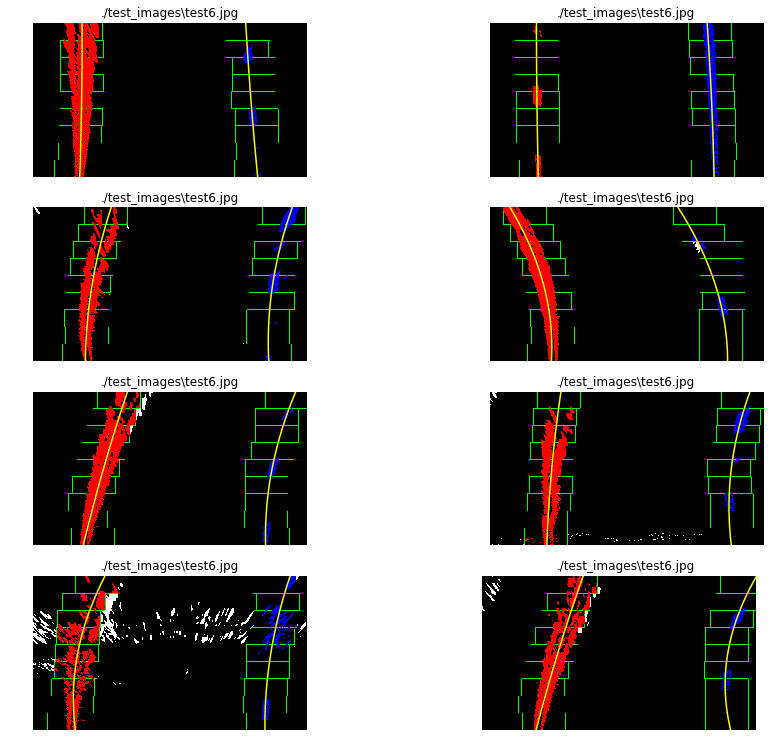

In [25]:
rows = 4
cols = 2
images_length = len(test_images_path)

fig, axes = plt.subplots(rows, cols, figsize=(15,13))
for ax, index in zip(axes.flat, range(cols * rows)):
    if index < images_length:
        # warped_binary_images list generated from above warped process
        image = warped_binary_images[index]
        
        visualizeLanes(image, ax)
        ax.set_title(image_path_name)
        ax.axis('off')
 

# Determine the curvature of the lane and vehicle position with respect to center.

In [26]:
def calculate_curvature(yRange, left_fit_cr):
   
   #  Returns the curvature of the polynomial `fit` on the y range `yRange`.
    
    
    return ((1 + (2*left_fit_cr[0]*yRange*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])



# Warp the detected lane boundaries back onto the original image.

In [27]:
def drawLine(img, left_fit, right_fit):
   # Draw the lane lines on the image `img` using the poly `left_fit` and `right_fit`.
   
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)


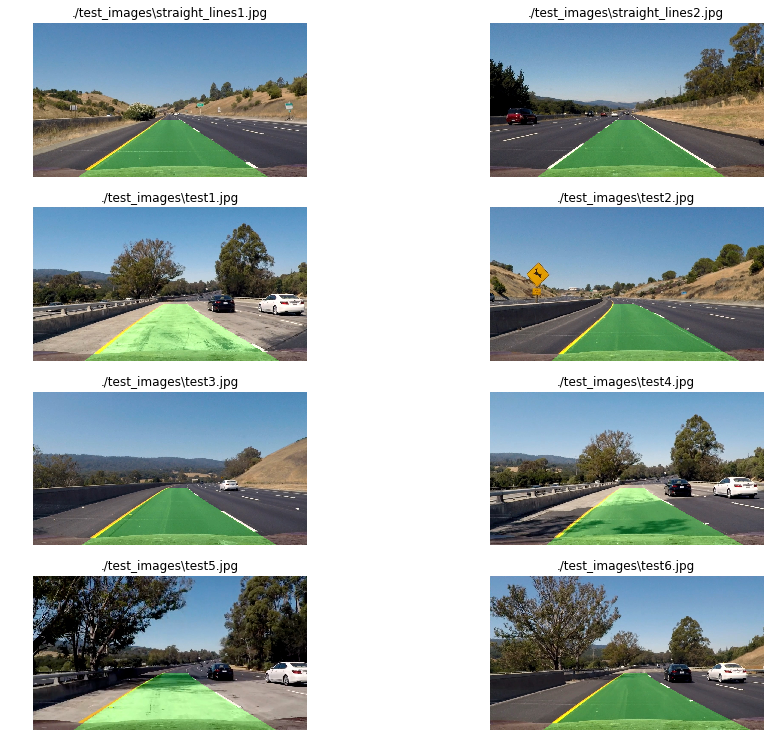

In [28]:
rows = 4
cols = 2
images_length = len(test_images_path)

fig, axes = plt.subplots(rows, cols, figsize=(15,13))
for ax, index in zip(axes.flat, range(cols * rows)):
    if index < images_length:
        # warped_binary_images list generated from above warped process
        origin_image_path = test_images_path[index]
        origin_image = mpimg.imread(origin_image_path)
        
        warped_binary_image = warped_binary_images[index]

        left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _ = findLines(warped_binary_image)
        result = drawLine(origin_image, left_fit, right_fit)
    
        ax.imshow(result)
        ax.set_title(origin_image_path)
        ax.axis('off')

# Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [29]:
def image_pipeline(img, binary_warped, fontScale=2):
    
   # Find and draw the lane lines on the image `img`.
 
    yRange = 719
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _ = findLines(binary_warped)
    output = drawLine(img, left_fit, right_fit)
    
    # Calculate curvature
    leftCurvature = calculate_curvature(yRange, left_fit_m) 
    rightCurvature = calculate_curvature(yRange, right_fit_m)
    
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
    
    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(output, 'Left curvature: {:.0f} m'.format(leftCurvature), (50, 50), font, fontScale, fontColor, 3)
    cv2.putText(output, 'Right curvature: {:.0f} m'.format(rightCurvature), (50, 120), font, fontScale, fontColor, 3)
    cv2.putText(output, 'Vehicle is {} of center'.format(message), (50, 190), font, fontScale, fontColor, 3)
    return output



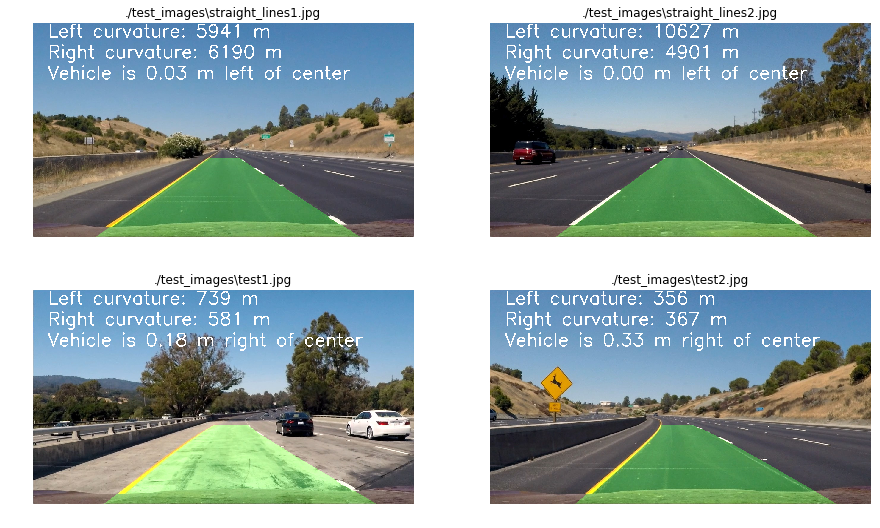

In [30]:
rows = 2
cols = 2
images_length = 4

fig, axes = plt.subplots(rows, cols, figsize=(15,9))
for ax, index in zip(axes.flat, range(cols * rows)):
    if index < images_length:
        # warped_binary_images list generated from above warped process
        origin_image_path = test_images_path[index]
        origin_image = mpimg.imread(origin_image_path)
        
        # convert to binary warped
        binary_warped = generate_binary_warped(origin_image)
        
        result = image_pipeline(origin_image, binary_warped)
    
        ax.imshow(result)
        ax.set_title(origin_image_path)
        ax.axis('off')

# Video pipeline

In [31]:
from moviepy.editor import VideoFileClip

class Lane():
    def __init__(self):
        self.left_fit = None
        self.right_fit = None
        self.left_fit_m = None
        self.right_fit_m = None
        self.leftCurvature = None
        self.rightCurvature = None

def calculate_lane_information(img):
    yRange = 719
    
    # Convert to binary_warped
    binary_warped = generate_binary_warped(img)

    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _ = findLines(binary_warped) 
    # Calculate curvature
    leftCurvature = calculate_curvature(yRange, left_fit_m) 
    rightCurvature = calculate_curvature(yRange, right_fit_m)
    
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle)

def displayLanes(img, left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle):
    
   # Display the lanes information on the image.
    
    output = drawLine(img, left_fit, right_fit)
    
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
    
    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(output, 'Left curvature: {:.0f} m'.format(leftCurvature), (50, 50), font, 1, fontColor, 2)
    cv2.putText(output, 'Right curvature: {:.0f} m'.format(rightCurvature), (50, 120), font, 1, fontColor, 2)
    cv2.putText(output, 'Vehicle is {} of center'.format(message), (50, 190), font, 1, fontColor, 2)
    return output
    
def videoPipeline(inputVideo, outputVideo):
    
    # Draw curvarute and vehicle position information frame by frame
    
    myclip = VideoFileClip(inputVideo)
    
    leftLane = Lane()
    rightLane = Lane()
    
    def processImage(img):
        left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle = calculate_lane_information(img)
        if leftCurvature > 10000:
            left_fit = leftLane.left_fit
            left_fit_m = leftLane.left_fit_m
            leftCurvature = leftLane.leftCurvature
        else:
            leftLane.left_fit = left_fit
            leftLane.left_fit_m = left_fit_m
            leftLane.leftCurvature = leftCurvature
        
        if rightCurvature > 10000:
            right_fit = rightLane.right_fit
            right_fit_m = rightLane.right_fit_m
            rightCurvature = rightLane.rightCurvature
        else:
            rightLane.right_fit = right_fit
            rightLane.right_fit_m = right_fit_m
            rightLane.rightCurvature = rightCurvature
            
        return displayLanes(img, left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle)

    clip = myclip.fl_image(processImage)
    clip.write_videofile(outputVideo, audio=False)


In [32]:

# Project video
videoPipeline('project_video.mp4', 'video_output/project_video_output.mp4')

[MoviePy] >>>> Building video video_output/project_video_output.mp4
[MoviePy] Writing video video_output/project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [07:31<00:00,  2.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output/project_video_output.mp4 

